In [1]:
# !pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tejveerchauhan","key":"8deb717d979865157490499d70160886"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d gpreda/covid19-tweets      

 79% 22.0M/27.9M [00:01<00:00, 17.6MB/s]
100% 27.9M/27.9M [00:01<00:00, 25.1MB/s]


In [4]:
from zipfile import ZipFile
filename = '/content/covid19-tweets.zip'

with ZipFile(filename,'r') as zip:
  zip.extractall('/content/')
print('ABD')


ABD


In [170]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [190]:
import pandas as pd
import numpy as np
import datetime as dt

covid = pd.read_csv('/content/covid19_tweets.csv')
covid.dropna(subset=['hashtags'],inplace=True)
covid = covid[['date','text','hashtags']]

# lower the chars
covid['hashtags'] = covid['hashtags'].str.lower()
# Replace the punctuation
covid['hashtags'] = covid['hashtags'].str.replace('[^\w\s]','')
# Select only hastags which have covid and corona as texts
covid = covid[(covid['hashtags'].str.contains('covid')) | (covid['hashtags'].str.contains('corona'))][['date','text']]
covid['date'] = pd.to_datetime(covid['date']).dt.date

# Grouping and joining the text based on date feature
covid['text'] = covid.groupby(['date'])['text'].transform(lambda x: ' '.join(x))
covid = covid.drop_duplicates()
# covid = covid.to_frame()

covid['text_len'] = covid['text'].str.len()
print(covid.shape)
covid.head()


(26, 3)


,date,text,text_len
2,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...,1230060
16881,2020-07-24,It feels so good to be able to flip through li...,20126
17176,2020-07-26,Bravo sir. You're fast becoming one of the wor...,568078
24677,2020-07-27,"Why continued hand-hygiene, masks and social d...",556099
32176,2020-07-28,"#Odisha’s #COVID19 tally breached the 28,000 m...",550302


In [191]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

    

In [192]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [193]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(covid['text'].values):
    sentance = re.sub(r"[@][A-Za-z0-9_]+", "", sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = re.sub(r"[@]+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords and len(e) > 2)
    preprocessed_text.append(sentance.strip())

100%|██████████| 26/26 [00:04<00:00,  6.15it/s]


In [194]:
covid['preprocessed_text'] = preprocessed_text
covid['text_len_processed'] = covid['preprocessed_text'].str.len()
# Selecting relevant columns
covid = covid[['date','preprocessed_text']]
print(covid.shape)
covid.head()


(26, 2)


,date,preprocessed_text
2,2020-07-25,trump never claimed hoax claim effort one gift...
16881,2020-07-24,feels good able flip live games mlbopeningday ...
17176,2020-07-26,bravo sir fast becoming one worst presidents m...
24677,2020-07-27,continued hand hygiene masks social distancing...
32176,2020-07-28,odisha tally breached mark new cases death tol...


In [195]:
import datetime
covid = pd.concat([covid]*10)
covid = covid.drop('date',axis = 1)
covid['date'] = pd.date_range(start='2020-03-01', periods=len(covid), freq='D')
# covid['date'] = (pd.date_range(start=datetime.datetime(2020, 3, 1),periods=covid.shape[0],freq='min'))
# covid['date'] = pd.to_datetime(covid['date'],format='%Y%m%d')
print(covid.shape)
covid.head()

(260, 2)


,preprocessed_text,date
2,trump never claimed hoax claim effort one gift...,2020-03-01
16881,feels good able flip live games mlbopeningday ...,2020-03-02
17176,bravo sir fast becoming one worst presidents m...,2020-03-03
24677,continued hand hygiene masks social distancing...,2020-03-04
32176,odisha tally breached mark new cases death tol...,2020-03-05


In [178]:
covid.shape

(260, 2)

In [196]:
from sklearn.feature_selection import SelectKBest

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(covid['preprocessed_text'])

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(covid['preprocessed_text'])
IDF_Values = tf_idf_vect.idf_
feature_names = tf_idf_vect.get_feature_names()
filtered_indices = np.argwhere(((IDF_Values> 1.5) & (IDF_Values < 5) ))
filtered_indices = [idx[0] for idx in filtered_indices]

filtered_feature_names = {feature_names[i] for i in filtered_indices}

text_data_tfidf_final = []
for text in covid['preprocessed_text'].values:
  text_word_list = [word for word in text.split() if word in filtered_feature_names]
  text_data_tfidf_final.append(' '.join(text_word_list))

covid['preprocessed_text_tfidf'] = text_data_tfidf_final

covid['preprocessed_text_tfidf_len'] = covid['preprocessed_text_tfidf'].str.len()
covid = covid[['date','preprocessed_text_tfidf']]
print(covid.shape)
covid.head()


some sample features(unique words in the corpus) ['aaaah', 'aaaah shame', 'aaaand', 'aaaand lost', 'aaaannndd', 'aaaannndd counting', 'aaah', 'aaah days', 'aaas', 'aaas madhyapradesh']
(260, 2)


,date,preprocessed_text_tfidf
2,2020-03-01,appreciation recruiting recruiting covidpositi...
16881,2020-03-02,flip mlbopeningday earmarks geographers bounty...
17176,2020-03-03,bravo presidents failedpresident pourquoi les ...
24677,2020-03-04,industrialization lawmakers negotiate chambers...
32176,2020-03-05,breached climbed seve patie bmc bmc summit imp...


In [197]:
tf_idf_vect_final = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect_final.fit(covid['preprocessed_text_tfidf'])

print("Updated sample features(unique words in the corpus)",tf_idf_vect_final.get_feature_names()[0:10])
print('='*50)

tf_idf_final = tf_idf_vect_final.transform(covid['preprocessed_text_tfidf'])

print("Updated shape of out text TFIDF vectorizer ",tf_idf_final.get_shape())
print("Updated number of unique words including both unigrams and bigrams ", tf_idf_final.get_shape()[1])
print("="*50)
 
final_text_features = tf_idf_vect_final.get_feature_names()

final_text_features_list = []
final_text_features_list.append('date')
final_text_features_list.extend(final_text_features)
# print('Columns names are')
# print(final_text_features_list)

Updated sample features(unique words in the corpus) ['aaaah', 'aaaah oral', 'aaaand', 'aaaand unemploymentbenefits', 'aaaannndd', 'aaaannndd biased', 'aaah', 'aaah southwest', 'aaas', 'aaas madhyapradesh']
Updated shape of out text TFIDF vectorizer  (260, 223076)
Updated number of unique words including both unigrams and bigrams  223076


In [205]:
from scipy.sparse import hstack
tf_array_final = tf_idf_final.todense()

# date_f_final = np.array(covid['date'])#.reshape(-1,1)
date_f_final = covid['date'].astype(str).to_numpy().reshape(-1,1)

tf_idf_final_covid = np.hstack((date_f_final,tf_array_final))

tf_idf_final_covid_df = pd.DataFrame(tf_idf_final_covid,columns=final_text_features_list)
print('Shape of Covid tweets is ',tf_idf_final_covid_df.shape)
tf_idf_final_covid_df.head()


2       2020-03-01
16881   2020-03-02
17176   2020-03-03
24677   2020-03-04
32176   2020-03-05
Name: date, dtype: datetime64[ns]
[['2020-03-01']
 ['2020-03-02']
 ['2020-03-03']
 ['2020-03-04']
 ['2020-03-05']]
<class 'numpy.ndarray'>
Shape of Covid tweets is  (260, 223077)


,date,aaaah,aaaah oral,aaaand,aaaand unemploymentbenefits,aaaannndd,aaaannndd biased,aaah,aaah southwest,aaas,aaas madhyapradesh,aaas wuhanlaboratory,aachen,aachen pegylated,aacrcovid,aacrcovid shashita,aadhaar,aadhaar kellyanne,aadhaar undergoing,aadhar,aadhar navigating,aadhar plasmafaithphysics,aadhar redirected,aadi,aadi hai,aadiganesha,aadiganesha ganesh,aadiganesha happyganeshchaturthi,aadiganesha saturdaymorning,aadmi,aadmi harpal,aadr,aadr dental,aafweek,aafweek savelives,aage,aage bebas,aah,aah waive,aaima,...,zuha bloo,zulu,zulu andamans,zum,zum thema,zuma,zuma alreadyvideo,zuma labuan,zuma waited,zumas,zumas neck,zumawasbetter,zumawasbetter zimbabweanlivesmatter,zumba,zumba isindebele,zumbavirtual,zumbavirtual indiana,zupta,zupta ripandrewmlangeni,zurich,zurich gambia,zurich idiotic,zurich julie,zurich notmychild,zurich solid,zve,zve pane,zweitewelle,zweitewelle damning,zweli,zweli mkhize,zyada,zyada din,zydus,zydus cadila,zydus dedicatedtolife,zydus introduces,zydus pandemictech,zyduscadila,zyduscadila cheapest
0,2020-03-01,0,0,0,0,0,0,0,0,0.00865944,0.00432972,0.00432972,0,0,0,0,0,0,0,0.00731557,0.00432972,0.00432972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0129892,0.00432972,0.00432972,0.00432972,0.00432972,0.00432972,0,0,0,0,0,0,0.00432972,0.00432972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00650615,0,0.00432972,0,0.00432972,0,0
1,2020-03-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-03-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0156392,0.00781962,0.00781962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00660608,0.00660608,0,0,0,0,0,0,0,0,0
3,2020-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00821155,0.00821155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [206]:
print(type(tf_idf_final_covid_df['date']))
tf_idf_final_covid_df = tf_idf_final_covid_df.sort_values('date')
tf_idf_final_covid_df['date'] = tf_idf_final_covid_df['date'].astype(str).str.replace('-','')
tf_idf_final_covid_df['date'] = pd.to_datetime(tf_idf_final_covid_df['date'],format='%Y%m%d')
tf_idf_final_covid_df.head()

<class 'pandas.core.series.Series'>


,date,aaaah,aaaah oral,aaaand,aaaand unemploymentbenefits,aaaannndd,aaaannndd biased,aaah,aaah southwest,aaas,aaas madhyapradesh,aaas wuhanlaboratory,aachen,aachen pegylated,aacrcovid,aacrcovid shashita,aadhaar,aadhaar kellyanne,aadhaar undergoing,aadhar,aadhar navigating,aadhar plasmafaithphysics,aadhar redirected,aadi,aadi hai,aadiganesha,aadiganesha ganesh,aadiganesha happyganeshchaturthi,aadiganesha saturdaymorning,aadmi,aadmi harpal,aadr,aadr dental,aafweek,aafweek savelives,aage,aage bebas,aah,aah waive,aaima,...,zuha bloo,zulu,zulu andamans,zum,zum thema,zuma,zuma alreadyvideo,zuma labuan,zuma waited,zumas,zumas neck,zumawasbetter,zumawasbetter zimbabweanlivesmatter,zumba,zumba isindebele,zumbavirtual,zumbavirtual indiana,zupta,zupta ripandrewmlangeni,zurich,zurich gambia,zurich idiotic,zurich julie,zurich notmychild,zurich solid,zve,zve pane,zweitewelle,zweitewelle damning,zweli,zweli mkhize,zyada,zyada din,zydus,zydus cadila,zydus dedicatedtolife,zydus introduces,zydus pandemictech,zyduscadila,zyduscadila cheapest
0,2020-03-01,0,0,0,0,0,0,0,0,0.00865944,0.00432972,0.00432972,0,0,0,0,0,0,0,0.00731557,0.00432972,0.00432972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0129892,0.00432972,0.00432972,0.00432972,0.00432972,0.00432972,0,0,0,0,0,0,0.00432972,0.00432972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00650615,0,0.00432972,0,0.00432972,0,0
1,2020-03-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-03-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0156392,0.00781962,0.00781962,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00660608,0.00660608,0,0,0,0,0,0,0,0,0
3,2020-03-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00821155,0.00821155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-03-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Covid Daily Data

In [207]:
!kaggle datasets download -d sudalairajkumar/covid19-in-usa

covid19-in-usa.zip: Skipping, found more recently modified local copy (use --force to force download)


In [208]:
from zipfile import ZipFile
filename = '/content/covid19-in-usa.zip'

with ZipFile(filename,'r') as zip:
  zip.extractall('/content/')
print('ABD')


ABD


In [209]:
covid19 = pd.read_csv('/content/us_covid19_daily.csv')
covid19['date'] = pd.to_datetime(covid19['date'],format='%Y%m%d')
covid19 = covid19.sort_values('date')
covid19 = covid19.dropna()
print(covid19.shape)

# print(np.array(covid19['date']))
covid19.head()


(250, 25)


,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dateChecked,death,hospitalized,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
249,2020-04-01,56,224040,989609,59665.0,20906.0,27930.0,3937.0,256.0,561.0,32.0,7084.0,2020-04-01T24:00:00Z,5336.0,27930.0,1262834,2020-04-01T24:00:00Z,0,0,1004,4134,83448,26116,112497,2ba76178091b286b38e11380d77a0d959867d0f7
248,2020-04-02,56,252085,1082725,62097.0,22997.0,32128.0,4513.0,305.0,574.0,32.0,8586.0,2020-04-02T24:00:00Z,6514.0,32128.0,1385745,2020-04-02T24:00:00Z,0,0,1178,4198,93116,28045,122911,71bf6989c8f3c4fde6c1e8a11a3303affeb1d14e
247,2020-04-03,56,283923,1183277,61976.0,25777.0,36731.0,4928.0,335.0,623.0,39.0,10861.0,2020-04-03T24:00:00Z,7799.0,36731.0,1521120,2020-04-03T24:00:00Z,0,0,1285,4603,100552,31838,135375,a47b33098750e26ca34269111398d9e35833b1b6
246,2020-04-04,56,316808,1378675,15569.0,30268.0,41743.0,5500.0,403.0,656.0,39.0,12844.0,2020-04-04T24:00:00Z,9280.0,41743.0,1749364,2020-04-04T24:00:00Z,0,0,1481,5012,195398,32885,228244,396a1372d97ea8b0f31798030345c398f65e9356
245,2020-04-05,56,342463,1473279,17303.0,32180.0,45680.0,5811.0,609.0,652.0,39.0,14589.0,2020-04-05T24:00:00Z,10619.0,45680.0,1871590,2020-04-05T24:00:00Z,0,0,1339,3937,94604,25655,122226,5a972d90749c8f10bf8203bf1816d6f7ffae86d3


In [210]:
covid_merge = tf_idf_final_covid_df.merge(covid19,how='inner',left_on=['date'],right_on=['date'])
covid_merge = covid_merge.fillna('0')
print(covid_merge.shape)
covid_merge.head()


(229, 223101)


,date,aaaah,aaaah oral,aaaand,aaaand unemploymentbenefits,aaaannndd,aaaannndd biased,aaah,aaah southwest,aaas,aaas madhyapradesh,aaas wuhanlaboratory,aachen,aachen pegylated,aacrcovid,aacrcovid shashita,aadhaar,aadhaar kellyanne,aadhaar undergoing,aadhar,aadhar navigating,aadhar plasmafaithphysics,aadhar redirected,aadi,aadi hai,aadiganesha,aadiganesha ganesh,aadiganesha happyganeshchaturthi,aadiganesha saturdaymorning,aadmi,aadmi harpal,aadr,aadr dental,aafweek,aafweek savelives,aage,aage bebas,aah,aah waive,aaima,...,zurich solid,zve,zve pane,zweitewelle,zweitewelle damning,zweli,zweli mkhize,zyada,zyada din,zydus,zydus cadila,zydus dedicatedtolife,zydus introduces,zydus pandemictech,zyduscadila,zyduscadila cheapest,states,positive,negative,pending_y,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dateChecked,death,hospitalized,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash_y
0,2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,224040,989609,59665.0,20906.0,27930.0,3937.0,256.0,561.0,32.0,7084.0,2020-04-01T24:00:00Z,5336.0,27930.0,1262834,2020-04-01T24:00:00Z,0,0,1004,4134,83448,26116,112497,2ba76178091b286b38e11380d77a0d959867d0f7
1,2020-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.016621,0.016621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,252085,1082725,62097.0,22997.0,32128.0,4513.0,305.0,574.0,32.0,8586.0,2020-04-02T24:00:00Z,6514.0,32128.0,1385745,2020-04-02T24:00:00Z,0,0,1178,4198,93116,28045,122911,71bf6989c8f3c4fde6c1e8a11a3303affeb1d14e
2,2020-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,283923,1183277,61976.0,25777.0,36731.0,4928.0,335.0,623.0,39.0,10861.0,2020-04-03T24:00:00Z,7799.0,36731.0,1521120,2020-04-03T24:00:00Z,0,0,1285,4603,100552,31838,135375,a47b33098750e26ca34269111398d9e35833b1b6
3,2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,316808,1378675,15569.0,30268.0,41743.0,5500.0,403.0,656.0,39.0,12844.0,2020-04-04T24:00:00Z,9280.0,41743.0,1749364,2020-04-04T24:00:00Z,0,0,1481,5012,195398,32885,228244,396a1372d97ea8b0f31798030345c398f65e9356
4,2020-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,342463,1473279,17303.0,32180.0,45680.0,5811.0,609.0,652.0,39.0,14589.0,2020-04-05T24:00:00Z,10619.0,45680.0,1871590,2020-04-05T24:00:00Z,0,0,1339,3937,94604,25655,122226,5a972d90749c8f10bf8203bf1816d6f7ffae86d3


In [20]:
covid_merge.head()

,date,abandoned,abortion,abou,abpoli,absence,abstract,abu,abu dhabi,abudhabi,abuse,academy,acc,acceptable,accepted,accessible,accident,accidents,acco,accountability,accountable,accounted,accuracy,achieved,achievement,acknowledge,acquired,acted,acti,actively,actors,actress,acts,addiction,addressed,adequate,adhere,adjusting,admission,admissions,...,yan,yang,yang speeches,yashoda,yay,yea,yellow,yemen,yester,yogi,yorkers,youngest,yrs,yup,zambia,zinc,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dateChecked,death,hospitalized,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,2020-07-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56,4083294,45903772,3409.0,59808.0,285288.0,10395.0,13182.0,2711.0,1297.0,1260741.0,2020-07-24T24:00:00Z,137556.0,285288.0,52854710,2020-07-24T24:00:00Z,0,0,1192,3040,852820,74854,1003121,37d340b8d45a80650e3b3023fd3893828d49ae09
1,2020-07-25,0.006219,0.000000,0.027143,0.011867,0.020810,0.024875,0.005429,0.005671,0.017014,0.010405,0.018656,0.010405,0.011343,0.005429,0.006219,0.000000,0.023735,0.000000,0.012438,0.005671,0.006219,0.0000,0.005934,0.006219,0.015608,0.006219,0.000000,0.009982,0.010857,0.005934,0.018656,0.012438,0.072836,0.000000,0.010857,0.010405,0.000000,0.010857,0.005203,...,0.0,0.006219,0.006219,0.022686,0.005934,0.005429,0.010857,0.014973,0.093282,0.024875,0.005934,0.005203,0.024955,0.011867,0.024875,0.010405,56,4147670,46620498,3377.0,59382.0,287099.0,10380.0,13279.0,2729.0,1300.0,1278557.0,2020-07-25T24:00:00Z,138561.0,287099.0,53735404,2020-07-25T24:00:00Z,0,0,1005,1811,716726,64376,880694,31c3fce38843e0319b772df1bd1ebcd58b266a36
2,2020-07-26,0.000000,0.000000,0.010039,0.010973,0.000000,0.000000,0.010039,0.010488,0.020976,0.028862,0.000000,0.009621,0.000000,0.000000,0.000000,0.000000,0.000000,0.010973,0.000000,0.010488,0.000000,0.0115,0.000000,0.000000,0.019241,0.000000,0.011500,0.000000,0.000000,0.000000,0.000000,0.023000,0.009621,0.000000,0.020078,0.019241,0.000000,0.040155,0.000000,...,0.0,0.011500,0.011500,0.031463,0.010973,0.010039,0.000000,0.000000,0.138000,0.069000,0.000000,0.009621,0.000000,0.000000,0.034500,0.028862,56,4207793,47397253,3361.0,58731.0,288479.0,10353.0,13343.0,2723.0,1336.0,1296974.0,2020-07-26T24:00:00Z,139121.0,288479.0,54628668,2020-07-26T24:00:00Z,0,0,560,1380,776755,60123,893264,fbdd8512346d45ad0b83316ea9163bab2be22562
3,2020-07-27,0.014282,0.023896,0.012467,0.013627,0.000000,0.014282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013025,0.000000,0.028564,0.000000,0.013627,0.013627,0.028564,0.026050,0.014282,0.0000,0.000000,0.014282,0.000000,0.000000,0.042846,0.000000,0.012467,0.040882,0.042846,0.000000,0.000000,0.022925,0.000000,0.000000,0.014282,0.000000,0.011948,...,0.0,0.028564,0.014282,0.000000,0.000000,0.000000,0.024935,0.022925,0.128539,0.000000,0.000000,0.047793,0.034388,0.000000,0.000000,0.000000,56,4262807,48099212,3398.0,58991.0,290150.0,10328.0,13412.0,2720.0,1356.0,1324925.0,2020-07-27T24:00:00Z,140186.0,290150.0,55453238,2020-07-27T24:00:00Z,0,0,1065,1671,701959,55014,824570,8e9d579c04832bb423e3b328be074906d5579467
4,2020-07-28,0.000000,0.012254,0.000000,0.083855,0.012254,0.000000,0.038358,0.040074,0.000000,0.012254,0.000000,0.024507,0.000000,0.012786,0.000000,0.014647,0.000000,0.000000,0.000000,0.026716,0.000000,0.0000,0.000000,0.000000,0.049015,0.000000,0.014647,0.011756,0.038358,0.000000,

In [211]:
covid_merge['nextday'] = covid_merge['positiveIncrease'].shift(1)
covid_merge = covid_merge.fillna(0)
covid_merge.head()


,date,aaaah,aaaah oral,aaaand,aaaand unemploymentbenefits,aaaannndd,aaaannndd biased,aaah,aaah southwest,aaas,aaas madhyapradesh,aaas wuhanlaboratory,aachen,aachen pegylated,aacrcovid,aacrcovid shashita,aadhaar,aadhaar kellyanne,aadhaar undergoing,aadhar,aadhar navigating,aadhar plasmafaithphysics,aadhar redirected,aadi,aadi hai,aadiganesha,aadiganesha ganesh,aadiganesha happyganeshchaturthi,aadiganesha saturdaymorning,aadmi,aadmi harpal,aadr,aadr dental,aafweek,aafweek savelives,aage,aage bebas,aah,aah waive,aaima,...,zve,zve pane,zweitewelle,zweitewelle damning,zweli,zweli mkhize,zyada,zyada din,zydus,zydus cadila,zydus dedicatedtolife,zydus introduces,zydus pandemictech,zyduscadila,zyduscadila cheapest,states,positive,negative,pending_y,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dateChecked,death,hospitalized,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash_y,nextday
0,2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,224040,989609,59665.0,20906.0,27930.0,3937.0,256.0,561.0,32.0,7084.0,2020-04-01T24:00:00Z,5336.0,27930.0,1262834,2020-04-01T24:00:00Z,0,0,1004,4134,83448,26116,112497,2ba76178091b286b38e11380d77a0d959867d0f7,0.0
1,2020-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.016621,0.016621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,252085,1082725,62097.0,22997.0,32128.0,4513.0,305.0,574.0,32.0,8586.0,2020-04-02T24:00:00Z,6514.0,32128.0,1385745,2020-04-02T24:00:00Z,0,0,1178,4198,93116,28045,122911,71bf6989c8f3c4fde6c1e8a11a3303affeb1d14e,26116.0
2,2020-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,283923,1183277,61976.0,25777.0,36731.0,4928.0,335.0,623.0,39.0,10861.0,2020-04-03T24:00:00Z,7799.0,36731.0,1521120,2020-04-03T24:00:00Z,0,0,1285,4603,100552,31838,135375,a47b33098750e26ca34269111398d9e35833b1b6,28045.0
3,2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,316808,1378675,15569.0,30268.0,41743.0,5500.0,403.0,656.0,39.0,12844.0,2020-04-04T24:00:00Z,9280.0,41743.0,1749364,2020-04-04T24:00:00Z,0,0,1481,5012,195398,32885,228244,396a1372d97ea8b0f31798030345c398f65e9356,31838.0
4,2020-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,342463,1473279,17303.0,32180.0,45680.0,5811.0,609.0,652.0,39.0,14589.0,2020-04-05T24:00:00Z,10619.0,45680.0,1871590,2020-04-05T24:00:00Z,0,0,1339,3937,94604,25655,122226,5a972d90749c8f10bf8203bf1816d6f7ffae86d3,32885.0


In [34]:
# covid_merge_df = covid_merge[['date','positiveIncrease','nextday']]
# covid_merge_df.head()

## Data Visualization

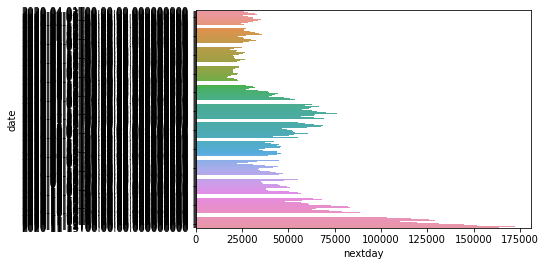

In [212]:
import seaborn as sns

sns.barplot(covid_merge['nextday'],covid_merge['date'])
# sns.boxplot(covid_merge_df['nextday'],covid_merge_df['date'])

In [115]:
# # import datetime as dt
# # # print(type(covid_merge['date']))
# # date1 = pd.DataFrame(covid_merge['date']).astype('str')
# # # print(date1)
# # # print(type(date1))
# # sns.jointplot(date1['date'], 'nextday', data=covid_merge, kind='reg')
# # print(covid_merge['date'].astype(str).replace('-',''))
# # xtickangle(45)

# import datetime as dt
# # covid_merge['date'] = pd.to_datetime(covid_merge['date'],format='ddmmyyyy')

# date = covid_merge['date'].astype('str').str.replace('-','')
# # covid_merge['date']=covid_merge['date'].map(dt.datetime.toordinal)
# sns.jointplot(date, 'nextday', data=covid_merge, kind='reg')

In [216]:
dates = sorted(covid_merge['date'])
split = dates[int(len(dates) * 0.8)]
train_df = covid_merge.loc[covid_merge['date'] < split]
test_df = covid_merge.loc[covid_merge['date'] >= split]
y_train = train_df['nextday']
x_train = train_df.drop(['nextday','date','dateChecked','lastModified','hash_y'],axis=1)
y_test = test_df['nextday']
x_test = test_df.drop(['nextday','date','dateChecked','lastModified','hash_y'],axis=1)
print('Train DF is ',train_df.shape)
print('Test DF is ',test_df.shape)
print('X _train is',x_train.shape)
print('X _test is',x_test.shape)
print('y _train is',y_train.shape)
print('y _test is',y_test.shape)

x_train.head()

Train DF is  (183, 223102)
Test DF is  (46, 223102)
X _train is (183, 223097)
X _test is (46, 223097)
y _train is (183,)
y _test is (46,)


,aaaah,aaaah oral,aaaand,aaaand unemploymentbenefits,aaaannndd,aaaannndd biased,aaah,aaah southwest,aaas,aaas madhyapradesh,aaas wuhanlaboratory,aachen,aachen pegylated,aacrcovid,aacrcovid shashita,aadhaar,aadhaar kellyanne,aadhaar undergoing,aadhar,aadhar navigating,aadhar plasmafaithphysics,aadhar redirected,aadi,aadi hai,aadiganesha,aadiganesha ganesh,aadiganesha happyganeshchaturthi,aadiganesha saturdaymorning,aadmi,aadmi harpal,aadr,aadr dental,aafweek,aafweek savelives,aage,aage bebas,aah,aah waive,aaima,aaima covidmask,...,zurich idiotic,zurich julie,zurich notmychild,zurich solid,zve,zve pane,zweitewelle,zweitewelle damning,zweli,zweli mkhize,zyada,zyada din,zydus,zydus cadila,zydus dedicatedtolife,zydus introduces,zydus pandemictech,zyduscadila,zyduscadila cheapest,states,positive,negative,pending_y,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,totalTestResults,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.011948,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,224040,989609,59665.0,20906.0,27930.0,3937.0,256.0,561.0,32.0,7084.0,5336.0,27930.0,1262834,0,0,1004,4134,83448,26116,112497
1,0.0,0.0,0.0,0.0,0.0,0.0,0.016621,0.016621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,252085,1082725,62097.0,22997.0,32128.0,4513.0,305.0,574.0,32.0,8586.0,6514.0,32128.0,1385745,0,0,1178,4198,93116,28045,122911
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007769,0.007769,...,0.000000,0.000000,0.007769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,283923,1183277,61976.0,25777.0,36731.0,4928.0,335.0,623.0,39.0,10861.0,7799.0,36731.0,1521120,0,0,1285,4603,100552,31838,135375
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,316808,1378675,15569.0,30268.0,41743.0,5500.0,403.0,656.0,39.0,12844.0,9280.0,41743.0,1749364,0,0,1481,5012,195398,32885,228244
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.007459,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56,342463,1473279,17303.0,32180.0,45680.0,5811.0,609.0,652.0,39.0,14589.0,10619.0,45680.0,1871590,0,0,1339,3937,94604,25655,122226


### Linear Model

In [217]:
lr = LinearRegression()
lr.fit(x_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [96]:
y_predict = lr.predict(x_test)


In [97]:
#Parameters used for the model 
lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [98]:
print('Co-efficient of linear regression',lr.coef_)

Co-efficient of linear regression [-3.72674198e+01 -9.74423901e+01  3.11931062e+02 ... -3.74283648e-02
  1.76305955e-01  9.89248105e-02]


In [99]:
print('Intercept of linear regression model',lr.intercept_)

Intercept of linear regression model 403755.3553792625


In [100]:
print('Mean Square Error', metrics.mean_squared_error(y_test, y_predict))

Mean Square Error 11049365867.644836


In [112]:
print('Predicted:')
print(np.round(y_predict,0))
print('='*30)
print('y_test')
print(np.array(np.round(y_test,0)))
print('='*30)
print('Difference')
print(np.array(np.round((y_predict-y_test),0)))

Predicted:
[  76336.   57425.   38623.  -44756. -126478. -125673.]
y_test
[57093. 42322. 37411. 40492. 45722. 43963.]
Difference
[  19243.   15103.    1212.  -85248. -172200. -169636.]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<Figure size 432x288 with 0 Axes>

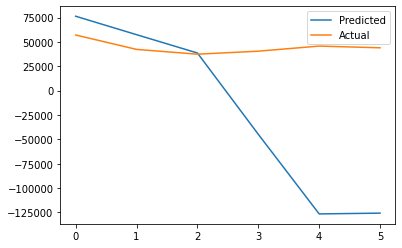

In [121]:
y_test = np.array(y_test)
print(type(y_test))
print(type(y_predict))
plt.clf()
f, ax = plt.subplots(1)
ax.plot(y_predict,'-',label='Predicted')
ax.plot(y_test,'-',label='Actual')
plt.legend()

In [76]:
!kaggle datasets download -d paulrohan2020/covid19-unique-tweets

100% 1.82G/1.82G [00:31<00:00, 54.9MB/s]
100% 1.82G/1.82G [00:31<00:00, 62.7MB/s]


In [77]:
from zipfile import ZipFile
filename = '/content/covid19-unique-tweets.zip'

with ZipFile(filename,'r') as zip:
  zip.extractall('/content/')
print('ABD')


ABD


Train 196, test 49, 80 percent split
Predicted:
[ 31417.85115964  30289.67635949  32423.09248021  43788.03880413
  42329.85681705  43369.71470138  37037.8311161   28498.55134728
  34562.42847604  50322.61013821  41335.20806592  46257.32310912
  50893.34522403  37280.451756    29981.32604666  32651.80962529
  34266.72649333  49542.31571645  42326.65076526  98606.49439406
  60550.18735093  39155.69793756  39116.27218986  37691.19828573
  47473.15862068  54421.28019574  53770.29055307  45309.84515453
  41412.40196645  43462.43783727  42193.99443489  58210.31779543
  63273.40068269  64997.6894074   55165.05038171  46551.19011359
  61564.27938165  67015.38950098  64654.95870113  76348.7367871
  89508.84593593  79250.9929743   69081.12965357  87366.22990669
  98259.8919228   90452.47529712 100865.82049905 121521.1741279
 144553.4023034 ]
Actual:
[33620 34905 40112 43289 47252 44905 35503 39139 49475 38620 43346 55189
 47405 34986 35883 36441 44347 45605 49258 50934 37987 37757 38917 50591
 5

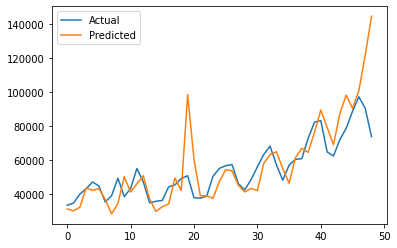

In [78]:
import pyspark
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re

from functools import partial
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# process unigram data

def process_row(features, row):
  word = row.__getitem__('word1')
  freq = int(row.__getitem__('n'))
  date = row.__getitem__('date')
  if word not in features:
    return
  yield (date.split('T')[0].replace('-', ''), np.array([freq if w == word else 0 for w in features]))

def build_word_frequency_by_date(tweets, features):
  t = tweets.rdd.flatMap(partial(process_row, features)).reduceByKey(lambda l, r: l+r)
  t = t.filter(lambda r: r[0] >= '20200301') # filter to Mar 1 when cases started rising
  return t

# Linear regression model

K = 4 # set number of partitions to use when building model

def to_freq_vector(words, features):
  # limit to a smaller number of words to prevent overfitting
  return [words.get(w, 0) for w in features]

def build_model(stream):
  # stream: a generator of (date, (bag of words, label))
  # Load word index from pickle (run wordcount first)
  data = list(stream)
  # print(data)
  d = [c[0] for c in data] 
  x = np.array([c[0] for c in data]) # features
  y = np.array([q[1] for q in data]) # labels
  if len(x) == 0:
    return
  print('Partition dataset size %d' % len(y))
  # we can change which model to use here
  reg = LinearRegression().fit(x, y)
  yield reg

# Model evaluators

def produce_scatterplot(x, y, xlab, ylab, filename, line=False):
  plt.clf()
  plt.scatter(x, y)
  if line:
    t = [np.min(x), np.max(x)]
    plt.plot(t, t, '--')
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.savefig(filename)

def produce_lineplot(y1, y2, lab1, lab2, filename):
  plt.clf()
  plt.plot(y1, '-', label=lab1)
  plt.plot(y2, '-', label=lab2)
  plt.legend()
  plt.savefig(filename)

def produce_hist(x, title, filename):
  plt.clf()
  plt.hist(x, rwidth=0.9)
  plt.title(title)
  plt.savefig(filename)

if __name__ == '__main__':
  spark = SparkSession.builder.getOrCreate()
  spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', 'true')

  tweets = spark.read.option('multiline', True).option('escape', '"').csv('/content/covid19_unique_tweets-master/bigrams/*csv', header=True)

  features = pickle.load(open('selected.pickle', 'rb'))
  x = build_word_frequency_by_date(tweets, features)

  # case numbers can easily fit into one pandas dataframe
  cases_pd = pd.read_csv('us_covid19_daily.csv')
  cases_pd['nextday'] = cases_pd['positiveIncrease'].shift(1) # get previous day numbers
  cases = spark.createDataFrame(cases_pd[['date', 'positiveIncrease', 'nextday']].dropna())
  y = cases.dropna().rdd.map(lambda r: (str(r[0]), (int(r[1]), int(r[2]))))

  # join and format to (date, (words, positive, nextday))
  df = x.join(y).map(lambda r: (r[0], (r[1][0], r[1][1][0], r[1][1][1])))
  # result = df.collect()
  # for row in result:
  #   print(row)

  # process into word frequency vectors and append current no. of cases to feature vector
  df = df.map(lambda r: (r[0], (np.append(r[1][0], r[1][1]), r[1][2])))

  dates = df.map(lambda r: r[0]).sortBy(lambda r: r).collect()

  # train test split by date then remove date from labels (not needed for our purposes)
  split = dates[int(len(dates) * 0.8)] # gets us an approximate 4:1 train:test split
  train_df = df.filter(lambda r: r[0] < split).map(lambda r: r[1])
  test_df = df.filter(lambda r: r[0] >= split).sortByKey().map(lambda r: r[1])
  xtest = np.array(test_df.map(lambda r: r[0]).collect())
  ytest = np.array(test_df.map(lambda r: r[1]).collect())

  train_size = train_df.count()
  test_size = test_df.count()

  # fit models
  models = train_df.repartition(K).mapPartitions(build_model).collect()

  # get bagging prediction results
  print('Train %d, test %d, %d percent split' % (train_size, test_size, 100 * train_size / (train_size + test_size)))
  bagging = np.array([model.predict(xtest) for model in models])
  ypred = np.mean(bagging, axis=0)
  print('Predicted:')
  print(ypred)
  print('Actual:')
  print(ytest)
  print('Diff:')
  print(ypred - ytest)
  print('Ratio:')
  print(ypred / ytest)
  print('Linear regression ensemble RMSE: %f' % np.sqrt(mean_squared_error(ypred, ytest)))

  # validation of general case
  print('Average case numbers: %f', np.mean(ytest))
  print('SD case numbers: %f', np.std(ytest))

  # Plot predicted next day cases against current day cases to check if we are actually doing anything useful
  produce_scatterplot(xtest.take(indices=-1, axis=1), ypred,
    xlab='Current day cases', ylab='Predicted next day cases', filename='lr_scatter.png')
  produce_scatterplot(ytest, ypred, 'Actual', 'Predicted', filename='lr_pred.png', line=True)
  produce_hist(ypred / ytest, 'Predicted to Actual Ratios', 'lr_ratio.png')
  produce_lineplot(ytest, ypred, 'Actual', 'Predicted', 'lr_trend.png')


In [72]:
!pip3 install pyspark

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 21.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=0553549248b3243f19bc9a4929a645da0da7d8b23e6c814337516ebf7041b71e
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
